In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneGroupOut
import matplotlib.pyplot as plt

In [2]:
D = pd.read_hdf('//FS2.smpp.local\RTO\CIS-PD MUSC\decoded_forms\\form509.h5')

In [3]:
sum(D.Q03=='Left')/len(D)

0.6700507614213198

## Tremor Scores

In [4]:
taskList = np.array(['Standing', 'Walking', 'Walking while counting', 'Finger to nose--right hand', 
                     'Finger to nose--left hand', 'Alternating right hand movements', 
                     'Alternating left hand movements', 'Sit to stand', 'Drawing on a paper', 
                     'Typing on a computer keyboard', 'Assembling nuts and bolts', 
                     'Taking a glass of water and drinking', 'Organizing sheets in a folder', 'Folding towels', 
                     'Sitting'])
taskList_Abb = np.array(['Stndg', 'Wlkg', 'WlkgCnt', 'FtnR', 'FtnL', 'RamR', 'RamL', 'SitStand', 
                         'Drwg', 'Typg', 'NtsBts', 'Drnkg', 'Sheets', 'Fldg', 'Sitng'])

In [5]:
Questions = pd.read_sas('//FS2.smpp.local\RTO\CIS-PD MUSC\datadictionary.sas7bdat')
Questions = Questions[Questions.zFormID == 509.0]
Questions = Questions.drop(columns = list(set(Questions.columns)-set(['zFieldNm','zFieldNb'])))
Questions.zFieldNm = Questions.zFieldNm.apply(
    lambda x: x.replace(b'\x92',b"'").replace(b'\x97',b'--').decode() if isinstance(x, bytes) else x)
Questions.zFieldNb = Questions.zFieldNb.apply(
    lambda x: x.replace(b'\x92',b"'").replace(b'\x97',b'--').decode() if isinstance(x, bytes) else x)
## Correct Typos
Questions.loc[Questions.zFieldNm=='Walking  tremor left upper limb rating','zFieldNm'] = 'Walking tremor left upper limb rating'
Questions.loc[Questions.zFieldNb=='Q70','zFieldNm'] = 'Alternating left hand movements tremor right upper limb rating'
Questions.loc[Questions.zFieldNb=='Q145','zFieldNm'] = 'Sitting tremor right upper limb rating'

In [6]:
AllScores = pd.DataFrame()
for ind in D.index:
    row = D.loc[ind,:]
    side = row.Q03
    if side == 'left':
        SideDict = {'FtnR': 'FtnC', 'FtnL': 'FtnI', 'RamR':'RamC', 'RamL':'RamI'}
    else:
        SideDict = {'FtnR': 'FtnI', 'FtnL': 'FtnC', 'RamR':'RamI', 'RamL':'RamC'}
        
    try:
        side = side.lower()
    except(AttributeError):
        print(row.SubjectCode, row.VisitNm, row.Q03)
        continue
    RowScores = pd.DataFrame(columns=taskList_Abb, index=[ind])
    for task, task_abr in zip(taskList,taskList_Abb):
        QInd = Questions.zFieldNm==task+' tremor '+side+' upper limb rating'
        QNum = Questions[QInd].zFieldNb
#         print(task+' tremor '+side+' upper limb rating',row[QNum].values)
        if task_abr in SideDict.keys():
            task_abr=SideDict[task_abr]
        RowScores[task_abr] = row[QNum].values[0]
    RowScores.index = [(row.SubjectCode,row.VisitNm)]
    AllScores = pd.concat((AllScores,RowScores))
    

1005.0 2 Weeks: Time 120 nan
1005.0 1 Month nan
1020.0 2 Weeks: Time 0 nan
1020.0 2 Weeks: Time 30 nan
1020.0 2 Weeks: Time 60 nan
1020.0 2 Weeks: Time 90 nan
1020.0 2 Weeks: Time 120 nan
1020.0 2 Weeks: Time 150 nan
1047.0 1 Month nan
1048.0 2 Weeks: Time 150 nan


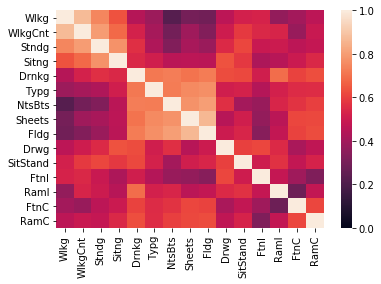

In [7]:
sns.heatmap(AllScores.corr().loc[['Wlkg','WlkgCnt','Stndg','Sitng','Drnkg','Typg','NtsBts','Sheets','Fldg','Drwg','SitStand','FtnI','RamI','FtnC','RamC'],
                                 ['Wlkg','WlkgCnt','Stndg','Sitng','Drnkg','Typg','NtsBts','Sheets','Fldg','Drwg','SitStand','FtnI','RamI','FtnC','RamC']]
           ,vmin=0, vmax=1)

In [8]:
AllScoresRMSE = pd.DataFrame(columns=AllScores.columns, index =AllScores.columns)
for x,y in itertools.product(AllScores.columns,AllScores.columns):
    AllScoresRMSE.loc[x,y] = ((AllScores[x]-AllScores[y])**2).mean()**.5

In [9]:
AllScoresRMSE = AllScoresRMSE[AllScoresRMSE.columns].astype(float)

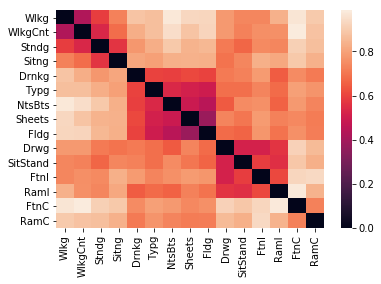

In [10]:
sns.heatmap(AllScoresRMSE.loc[['Wlkg','WlkgCnt','Stndg','Sitng','Drnkg','Typg','NtsBts','Sheets','Fldg','Drwg','SitStand','FtnI','RamI','FtnC','RamC'],
                              ['Wlkg','WlkgCnt','Stndg','Sitng','Drnkg','Typg','NtsBts','Sheets','Fldg','Drwg','SitStand','FtnI','RamI','FtnC','RamC']]
           ,vmin=0)

In [11]:
Tremor = AllScores
Tremor.drop(columns=['RamR','RamL','FtnR','FtnL'], inplace=True)
Tremor.columns = [c+'_T' for c in Tremor.columns]

## Bradykinesia Scores

In [12]:
taskList = np.array(['Walking', 'Walking while counting', 'Finger to nose--right hand', 
                     'Finger to nose--left hand', 'Alternating right hand movements', 
                     'Alternating left hand movements', 'Drawing on a paper', 
                     'Typing on a computer keyboard', 'Assembling nuts and bolts', 
                     'Taking a glass of water and drinking', 'Organizing sheets in a folder', 'Folding towels'])
taskList_Abb = np.array(['Wlkg', 'WlkgCnt', 'FtnR', 'FtnL', 'RamR', 'RamL', 
                         'Drwg', 'Typg', 'NtsBts', 'Drnkg', 'Sheets', 'Fldg'])

In [13]:
Questions = pd.read_sas('//FS2.smpp.local\RTO\CIS-PD MUSC\datadictionary.sas7bdat')
Questions = Questions[Questions.zFormID == 509.0]
Questions = Questions.drop(columns = list(set(Questions.columns)-set(['zFieldNm','zFieldNb'])))
Questions.zFieldNm = Questions.zFieldNm.apply(
    lambda x: x.replace(b'\x92',b"'").replace(b'\x97',b'--').decode() if isinstance(x, bytes) else x)
Questions.zFieldNb = Questions.zFieldNb.apply(
    lambda x: x.replace(b'\x92',b"'").replace(b'\x97',b'--').decode() if isinstance(x, bytes) else x)

In [14]:
AllScores = pd.DataFrame()
for ind in D.index:
    row = D.loc[ind,:]
    side = row.Q03
    if side == 'Left':
        SideDict = {'FtnR': 'FtnC', 'FtnL': 'FtnI', 'RamR':'RamC', 'RamL':'RamI'}
    else:
        SideDict = {'FtnR': 'FtnI', 'FtnL': 'FtnC', 'RamR':'RamI', 'RamL':'RamC'}
        
    try:
        side = side.lower()
    except(AttributeError):
        print(row.SubjectCode, row.VisitNm, row.Q03)
        continue
    RowScores = pd.DataFrame(columns=taskList_Abb, index=[ind])
    for task, task_abr in zip(taskList,taskList_Abb):
        if (task_abr[-1].lower()!=side[0])&((task_abr[-1]=='R')|(task_abr[-1]=='L')):
            continue
        QInd = Questions.zFieldNm==task+' bradykinesia '+side+' upper limb'
        if sum(QInd)<1:
            QInd = Questions.zFieldNm==task+' bradykinesia '+side+' upper limb rating'
        QNum = Questions[QInd].zFieldNb
#         print(task+' tremor '+side+' upper limb rating',row[QNum].values)
        if task_abr in SideDict.keys():
            task_abr=SideDict[task_abr]
        RowScores[task_abr] = row[QNum].values[0]
    RowScores.index = [(row.SubjectCode,row.VisitNm)]
    AllScores = pd.concat((AllScores,RowScores))
    

1005.0 2 Weeks: Time 120 nan
1005.0 1 Month nan
1020.0 2 Weeks: Time 0 nan
1020.0 2 Weeks: Time 30 nan
1020.0 2 Weeks: Time 60 nan
1020.0 2 Weeks: Time 90 nan
1020.0 2 Weeks: Time 120 nan
1020.0 2 Weeks: Time 150 nan
1047.0 1 Month nan
1048.0 2 Weeks: Time 150 nan


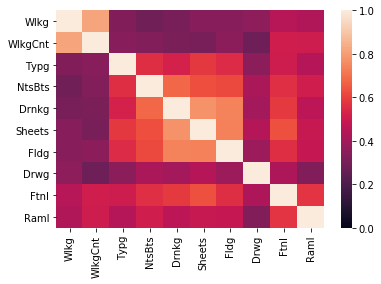

In [15]:
sns.heatmap(AllScores.corr().loc[['Wlkg','WlkgCnt','Typg','NtsBts','Drnkg','Sheets','Fldg','Drwg','FtnI','RamI'],
                                 ['Wlkg','WlkgCnt','Typg','NtsBts','Drnkg','Sheets','Fldg','Drwg','FtnI','RamI']],vmin=0, vmax=1)

In [16]:
AllScoresRMSE = pd.DataFrame(columns=AllScores.columns, index =AllScores.columns)
for x,y in itertools.product(AllScores.columns,AllScores.columns):
    AllScoresRMSE.loc[x,y] = ((AllScores[x]-AllScores[y])**2).mean()**.5

In [17]:
AllScoresRMSE = AllScoresRMSE[AllScoresRMSE.columns].astype(float)

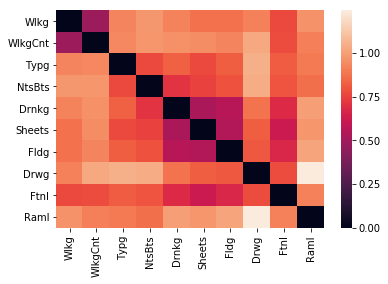

In [18]:
sns.heatmap(AllScoresRMSE.loc[['Wlkg','WlkgCnt','Typg','NtsBts','Drnkg','Sheets','Fldg','Drwg','FtnI','RamI'],
                              ['Wlkg','WlkgCnt','Typg','NtsBts','Drnkg','Sheets','Fldg','Drwg','FtnI','RamI']],vmin=0)

In [19]:
Brady = AllScores
Brady.drop(columns=['RamR','RamL','FtnR','FtnL'], inplace=True)
Brady.columns = [c+'_B' for c in Brady.columns]

## Corrleate with MDS-UPDRS

In [20]:
AllScores = pd.concat((Tremor,Brady),axis=1)

#### Extract MDS-UPDRS Scores

In [21]:
form508 = pd.read_hdf('//FS2.smpp.local\\RTO\\CIS-PD MUSC\\decoded_forms\\form508.h5')

In [22]:
form508.head(2)

,SubjectCode,SiteID,VisitNm,FormDate,Q33,Q34,Q35,Q36,Q37,Q38,...,Q64,Q65,Q02,Q01,Q66,Q67,Q68,DataCollected,Qb2_UTC,FormTime
0,1003.0,1313.0,2 Weeks: Time 0,2017-07-03,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,1.0,NaN,Off,No,NaN,Severe disability; still able to walk or stand...,Yes,2017-07-03 15:20:44,10:20:44
1,1003.0,1313.0,2 Weeks: Time 60,2017-07-03,1.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,NaN,On,No,NaN,Bilateral involvement without impairment of ba...,Yes,2017-07-03 17:11:39,12:11:39


In [23]:
UPDRS = form508[['SubjectCode', 'VisitNm', 'Q01', 'Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q45',
         'Q46', 'Q47', 'Q48', 'Q49', 'Q50', 'Q51', 'Q52', 'Q53', 'Q54', 'Q55',
         'Q56', 'Q57', 'Q58', 'Q59', 'Q60', 'Q61', 'Q62', 'Q63', 'Q64', 'Q65']].copy()
UPDRS.index = [(row[1].SubjectCode,row[1].VisitNm) for row in UPDRS.iterrows()]

In [24]:
UPDRS['UPDRS Part III'] = UPDRS[['Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q45',
         'Q46', 'Q47', 'Q48', 'Q49', 'Q50', 'Q51', 'Q52', 'Q53', 'Q54', 'Q55',
         'Q56', 'Q57', 'Q58', 'Q59', 'Q60', 'Q61', 'Q62', 'Q63', 'Q64', 'Q65']].apply(sum,axis=1)
UPDRS['UPDRS Rigidity'] = UPDRS[['Q35', 'Q36', 'Q37', 'Q38', 'Q39']].apply(sum,axis=1)
UPDRS['UPDRS Upper'] = UPDRS[['Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q45']].apply(sum,axis=1)
UPDRS['UPDRS Lower'] = UPDRS[['Q46', 'Q47', 'Q48', 'Q49']].apply(sum,axis=1)
UPDRS['UPDRS Posture/Gait'] = UPDRS[['Q50', 'Q51', 'Q52', 'Q53', 'Q54']].apply(sum,axis=1)
UPDRS['UPDRS Bradykinesia'] = UPDRS[['Q55']].apply(sum,axis=1)
UPDRS['UPDRS Tremor'] = UPDRS[['Q56', 'Q57', 'Q58', 'Q59', 'Q60', 'Q61', 'Q62', 'Q63', 'Q64', 'Q65']].apply(sum,axis=1)

In [25]:
UPDRS

,SubjectCode,VisitNm,Q01,Q33,Q34,Q35,Q36,Q37,Q38,Q39,...,Q63,Q64,Q65,UPDRS Part III,UPDRS Rigidity,UPDRS Upper,UPDRS Lower,UPDRS Posture/Gait,UPDRS Bradykinesia,UPDRS Tremor
"(1003.0, 2 Weeks: Time 0)",1003.0,2 Weeks: Time 0,Off,2.0,2.0,2.0,2.0,2.0,2.0,1.0,...,0.0,0.0,1.0,59.0,9.0,13.0,11.0,11.0,3.0,8.0
"(1003.0, 2 Weeks: Time 60)",1003.0,2 Weeks: Time 60,On,1.0,2.0,2.0,2.0,2.0,2.0,1.0,...,0.0,0.0,0.0,40.0,9.0,12.0,6.0,3.0,2.0,5.0
"(1004.0, 2 Weeks: Time 0)",1004.0,2 Weeks: Time 0,Off,1.0,1.0,0.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,31.0,5.0,9.0,8.0,1.0,2.0,4.0
"(1004.0, 2 Weeks: Time 60)",1004.0,2 Weeks: Time 60,On,NaN,NaN,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,NaN,3.0,4.0,4.0,0.0,1.0,0.0
"(1005.0, 2 Weeks: Time 0)",1005.0,2 Weeks: Time 0,Off,1.0,1.0,1.0,1.0,2.0,1.0,2.0,...,0.0,0.0,1.0,33.0,7.0,8.0,8.0,2.0,2.0,4.0
"(1005.0, 2 Weeks: Time 60)",1005.0,2 Weeks: Time 60,On,1.0,1.0,2.0,0.0,3.0,0.0,2.0,...,0.0,0.0,1.0,32.0,7.0,8.0,5.0,2.0,1.0,7.0
"(1007.0, 2 Weeks: Time 0)",1007.0,2 Weeks: Time 0,Off,0.0,0.0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,2.0,33.0,5.0,10.0,7.0,2.0,2.0,7.0
"(1007.0, 2 Weeks: Time 60)",1007.0,2 Weeks: Time 60,On,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,16.0,0.0,7.0,4.0,1.0,1.0,2.0
"(1009.0, 2 Weeks: Time 0)",1009.0,2 Weeks: Time 0,Off,1.0,2.0,3.0,3.0,2.0,3.0,2.0,...,0.0,0.0,4.0,55.0,13.0,12.0,6.0,3.0,2.0,16.0
"(1009.0, 2 Weeks: Time 60)",1009.0,2 Weeks: Time 60,On,1.0,1.0,2.0,2.0,2.0,1.0,0.0,...,0.0,0.0,1.0,26.0,7.0,5.0,4.0,2.0,2.0,4.0


In [26]:
UPDRS=UPDRS[['UPDRS Part III', 'UPDRS Rigidity', 'UPDRS Upper', 'UPDRS Lower', 
             'UPDRS Posture/Gait', 'UPDRS Bradykinesia', 'UPDRS Tremor']]

#### Combine UPDRS and Motor Assessment Scores

In [27]:
CombScores = pd.concat((AllScores,UPDRS),axis=1)

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


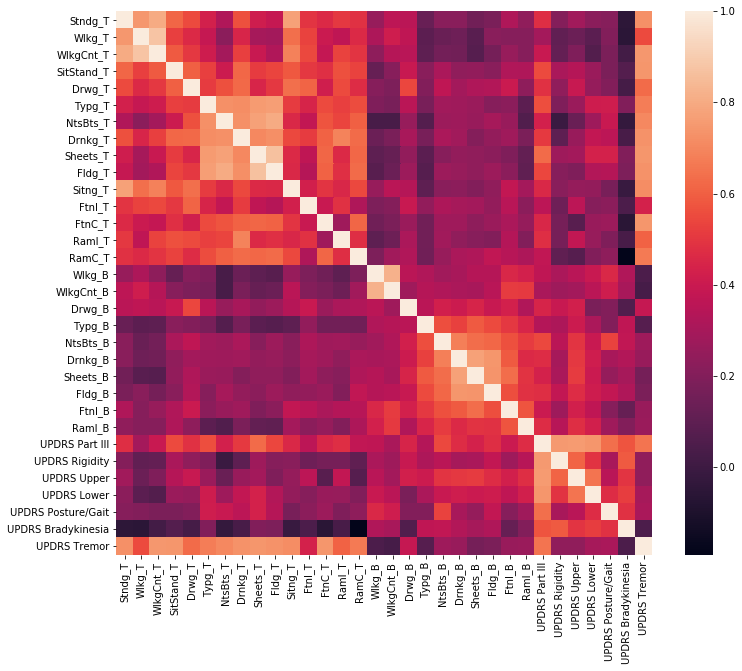

In [28]:
plt.figure(figsize=(12,10))
sns.heatmap(CombScores.corr())

In [29]:
CombScores.head()

Stndg_T  Wlkg_T  WlkgCnt_T  SitStand_T  Drwg_T  \
1003.0 1 Month                0.0     0.0        0.0         0.0     0.0   
       2 Weeks: Time 0        1.0     0.0        0.0         0.0     1.0   
       2 Weeks: Time 120      1.0     0.0        0.0         1.0     0.0   
       2 Weeks: Time 150      0.0     1.0        0.0         0.0     0.0   
       2 Weeks: Time 30       0.0     0.0        0.0         0.0     0.0   

                          Typg_T  NtsBts_T  Drnkg_T  Sheets_T  Fldg_T  \
1003.0 1 Month               0.0       1.0      1.0       0.0     0.0   
       2 Weeks: Time 0       0.0       1.0      1.0       2.0     1.0   
       2 Weeks: Time 120     0.0       0.0      0.0       0.0     0.0   
       2 Weeks: Time 150     0.0       0.0      1.0       0.0     0.0   
       2 Weeks: Time 30      1.0       0.0      1.0       0.0     0.0   

                              ...       Fldg_B  FtnI_B  RamI_B  \
1003.0 1 Month                ...          0.0     1.0     1.0   
       2 Weeks: Time 0        ...          1.0     1.0     2.0   
       2 Weeks: Time 120      ...          0.0     1.0     2.0   
       2 Weeks: Time 150      ...          0.0     0.0     1.0   
       2 Weeks: Time 30       ...          1.0     0.0     1.0   

                          UPDRS Part III  UPDRS Rigidity  UPDRS Upper  \
1003.0 1 Month                       NaN             NaN          NaN   
       2 Weeks: Time 0              59.0             9.0         13.0   
       2 Weeks: Time 120             NaN             NaN          NaN   
       2 Weeks: Time 150             NaN             NaN          NaN   
       2 Weeks: Time 30              NaN             NaN          NaN   

                          UPDRS Lower  UPDRS Posture/Gait  UPDRS Bradykinesia  \
1003.0 1 Month                    NaN                 NaN                 NaN   
       2 Weeks: Time 0           11.0                11.0                 3.0   
       2 Weeks: Time 120          NaN                 NaN                 NaN   
       2 Weeks: Time 150          NaN                 NaN                 NaN   
       2 Weeks: Time 30           NaN                 NaN                 NaN   

                          UPDRS Tremor  
1003.0 1 Month                     NaN  
       2 Weeks: Time 0             8.0  
       2 Weeks: Time 120           NaN  
       2 Weeks: Time 150           NaN  
       2 Weeks: Time 30            NaN  

[5 rows x 32 columns]

In [30]:
CombScores.corr().loc[['Stndg_T', 'Wlkg_T', 'WlkgCnt_T', 'SitStand_T', 'Drwg_T', 'Typg_T',
       'NtsBts_T', 'Drnkg_T', 'Sheets_T', 'Fldg_T', 'Sitng_T', 'FtnI_T',
       'FtnC_T', 'RamI_T', 'RamC_T', 'Wlkg_B', 'WlkgCnt_B', 'Drwg_B', 'Typg_B',
       'NtsBts_B', 'Drnkg_B', 'Sheets_B', 'Fldg_B', 'FtnI_B', 'RamI_B'],['UPDRS Part III']]

,UPDRS Part III
Stndg_T,0.474443
Wlkg_T,0.295790
WlkgCnt_T,0.399154
SitStand_T,0.551303
Drwg_T,0.486783
Typg_T,0.560636
NtsBts_T,0.429357
Drnkg_T,0.509991
Sheets_T,0.629058
Fldg_T,0.541484


### Random Forest for UPDRS Prediction

In [31]:
cf = RandomForestRegressor(n_estimators=50)
grouper = LeaveOneGroupOut()
CombScores.dropna(inplace=True)

In [32]:
CombScores.index.levels[0]

Float64Index([1003.0, 1004.0, 1005.0, 1007.0, 1009.0, 1016.0, 1018.0, 1019.0,
              1020.0, 1023.0, 1024.0, 1029.0, 1030.0, 1032.0, 1038.0, 1039.0,
              1043.0, 1044.0, 1046.0, 1047.0, 1048.0, 1049.0, 1050.0, 1051.0,
              1052.0, 1053.0, 1054.0, 1055.0, 1056.0],
             dtype='float64')

In [33]:
Outcomes = pd.DataFrame(index=CombScores.index,columns = ['UPDRS Part III', 'UPDRS Rigidity', 'UPDRS Upper', 'UPDRS Lower', 
                                                          'UPDRS Posture/Gait', 'UPDRS Bradykinesia', 'UPDRS Tremor'])
FeatImp = np.array([])
for subj in CombScores.index.levels[0]:
    try:
        if len(CombScores.loc[subj])<1:
            continue
    except(KeyError):
        continue
    for Target in Outcomes.columns:
        Train = CombScores.drop(index=subj)
        Test = CombScores.loc[subj]

        TrainFeat = Train.drop(columns=['UPDRS Part III', 'UPDRS Rigidity', 'UPDRS Upper', 'UPDRS Lower', 
                                        'UPDRS Posture/Gait', 'UPDRS Bradykinesia', 'UPDRS Tremor',
                                        'FtnI_T', 'FtnC_T', 'RamI_T', 'RamC_T', 'FtnI_B', 'RamI_B']).values
        TrainScores = Train[Target].values

        TestFeat = Test.drop(columns=['UPDRS Part III', 'UPDRS Rigidity', 'UPDRS Upper', 'UPDRS Lower', 
                                      'UPDRS Posture/Gait', 'UPDRS Bradykinesia', 'UPDRS Tremor',
                                      'FtnI_T', 'FtnC_T', 'RamI_T', 'RamC_T', 'FtnI_B', 'RamI_B']).values
        TestScores = Test[Target]
        
        cf.fit(TrainFeat,TrainScores)
        if Target=='UPDRS Part III':
            if len(FeatImp)>1:
                FeatImp=np.vstack((FeatImp,cf.feature_importances_))
            else:
                FeatImp = cf.feature_importances_
        pred = cf.predict(TestFeat)
        for ind in range(TestScores.shape[0]):
            Outcomes.loc[(subj, TestScores.index[ind]),Target] = (pred[ind],TestScores.iloc[ind])
    
    

In [34]:
Test

,Stndg_T,Wlkg_T,WlkgCnt_T,SitStand_T,Drwg_T,Typg_T,NtsBts_T,Drnkg_T,Sheets_T,Fldg_T,...,Fldg_B,FtnI_B,RamI_B,UPDRS Part III,UPDRS Rigidity,UPDRS Upper,UPDRS Lower,UPDRS Posture/Gait,UPDRS Bradykinesia,UPDRS Tremor
2 Weeks: Time 0,2.0,0.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,2.0,2.0,46.0,8.0,10.0,5.0,4.0,2.0,12.0
2 Weeks: Time 60,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,2.0,2.0,3.0,61.0,10.0,9.0,6.0,9.0,2.0,20.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

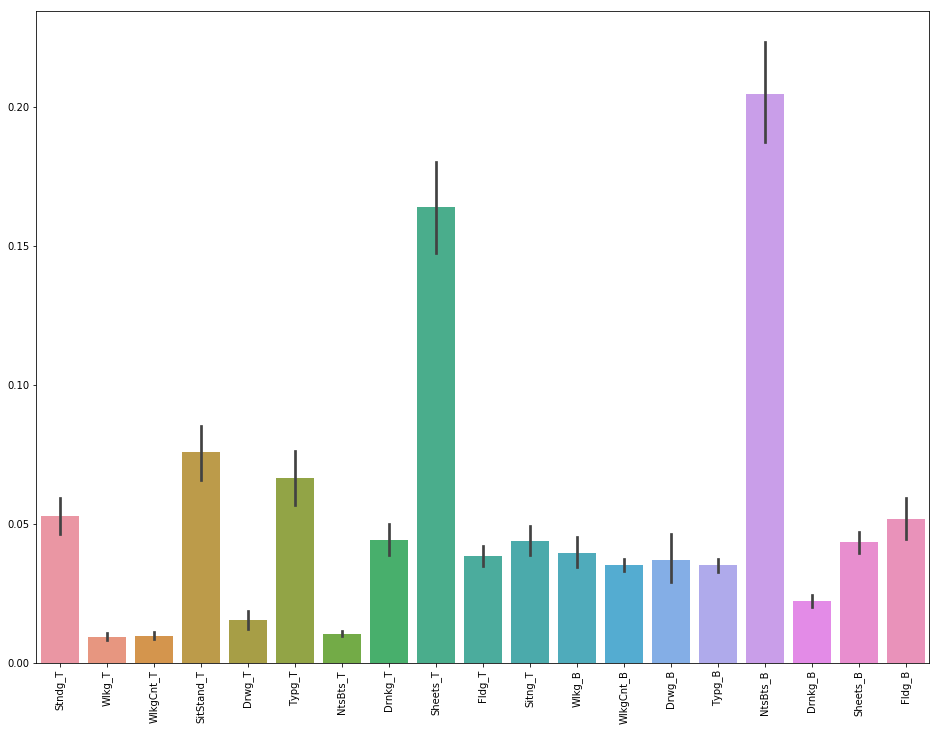

In [35]:
plt.figure(figsize=(16,12))
sns.barplot(data = pd.DataFrame(FeatImp,columns = AllScores.drop(columns=['FtnI_T', 'FtnC_T', 'RamI_T', 'RamC_T', 
                                                                          'FtnI_B', 'RamI_B']).columns))
plt.xticks(rotation=90)

In [36]:
FeatImp

array([[0.05281583, 0.00764199, 0.02336684, 0.00944501, 0.0200192 ,
        0.14529924, 0.01707667, 0.03618738, 0.09164309, 0.03045587,
        0.0392088 , 0.02037951, 0.02868519, 0.12686869, 0.03348583,
        0.1636023 , 0.03025887, 0.04971129, 0.07384841],
       [0.04146594, 0.00586961, 0.0080746 , 0.07604896, 0.01351823,
        0.07658812, 0.01217484, 0.03869137, 0.15090399, 0.041521  ,
        0.03811607, 0.03659535, 0.04473113, 0.02660214, 0.03402728,
        0.25327547, 0.02003695, 0.04443476, 0.0373242 ],
       [0.05297602, 0.00915758, 0.00777278, 0.04657876, 0.03966462,
        0.05920307, 0.0129712 , 0.04547281, 0.16383028, 0.03380868,
        0.0384026 , 0.04125005, 0.02581186, 0.04374643, 0.03404915,
        0.23084395, 0.01601299, 0.04625893, 0.05218826],
       [0.0554235 , 0.01160358, 0.00950907, 0.08159139, 0.00887431,
        0.05689248, 0.01085316, 0.04221909, 0.20506638, 0.05107427,
        0.05062014, 0.03028247, 0.05169713, 0.01126525, 0.02845175,
        0.187

In [37]:
Outcomes

UPDRS Part III  \
1003.0 2 Weeks: Time 0                (33.28, 59.0)   
       2 Weeks: Time 60  (15.868714285714288, 40.0)   
1004.0 2 Weeks: Time 0                (25.86, 31.0)   
1005.0 2 Weeks: Time 0                (32.46, 33.0)   
       2 Weeks: Time 60                (31.8, 32.0)   
1007.0 2 Weeks: Time 0                (25.18, 33.0)   
       2 Weeks: Time 60  (14.017000000000003, 16.0)   
1009.0 2 Weeks: Time 0                 (33.0, 55.0)   
       2 Weeks: Time 60               (21.18, 26.0)   
1016.0 2 Weeks: Time 0                 (24.1, 19.0)   
       2 Weeks: Time 60               (24.56, 21.0)   
1018.0 2 Weeks: Time 0                (26.96, 18.0)   
       2 Weeks: Time 60               (26.78, 13.0)   
1019.0 2 Weeks: Time 0   (17.206666666666667, 36.0)   
       2 Weeks: Time 60               (17.44, 14.0)   
1023.0 2 Weeks: Time 0                (30.56, 36.0)   
       2 Weeks: Time 60  (16.520833333333336, 21.0)   
1024.0 2 Weeks: Time 60               (25.24, 18.0)   
1029.0 2 Weeks: Time 0                (33.22, 42.0)   
       2 Weeks: Time 60               (21.12, 32.0)   
1030.0 2 Weeks: Time 0                (16.66, 18.0)   
1032.0 2 Weeks: Time 0                (30.36, 28.0)   
       2 Weeks: Time 60               (30.42, 12.0)   
1038.0 2 Weeks: Time 0    (34.58947619047619, 30.0)   
       2 Weeks: Time 60   (33.72947619047619, 25.0)   
1039.0 2 Weeks: Time 0                 (15.3, 29.0)   
       2 Weeks: Time 60              (19.315, 12.0)   
1043.0 2 Weeks: Time 0                (37.92, 40.0)   
       2 Weeks: Time 60  (19.218095238095238, 16.0)   
1044.0 2 Weeks: Time 0                (20.66, 29.0)   
       2 Weeks: Time 60  (11.392000000000001, 24.0)   
1046.0 2 Weeks: Time 0                (25.06, 21.0)   
       2 Weeks: Time 60               (28.78, 18.0)   
1047.0 2 Weeks: Time 0    (23.93254545454546, 18.0)   
       2 Weeks: Time 60   (15.578497835497835, 9.0)   
1048.0 2 Weeks: Time 0                (34.72, 16.0)   
1049.0 2 Weeks: Time 60               (30.06, 24.0)   
1050.0 2 Weeks: Time 0                (30.98, 40.0)   
       2 Weeks: Time 60               (23.04, 24.0)   
1051.0 2 Weeks: Time 0                (15.62, 14.0)   
       2 Weeks: Time 60   (16.148952380952377, 6.0)   
1052.0 2 Weeks: Time 0                (27.42, 31.0)   
       2 Weeks: Time 60               (16.96, 15.0)   
1053.0 2 Weeks: Time 0                (23.03, 25.0)   
       2 Weeks: Time 60   (13.47947619047619, 15.0)   
1054.0 2 Weeks: Time 0                 (33.5, 44.0)   
       2 Weeks: Time 60  (16.773785714285715, 15.0)   
1055.0 2 Weeks: Time 0                (40.96, 36.0)   
       2 Weeks: Time 60               (34.28, 26.0)   
1056.0 2 Weeks: Time 0                 (38.3, 46.0)   
       2 Weeks: Time 60                (43.0, 61.0)   

                                    UPDRS Rigidity  \
1003.0 2 Weeks: Time 0                  (3.1, 9.0)   
       2 Weeks: Time 60  (2.3804126984126985, 9.0)   
1004.0 2 Weeks: Time 0                 (1.98, 5.0)   
1005.0 2 Weeks: Time 0                 (7.22, 7.0)   
       2 Weeks: Time 60                 (6.9, 7.0)   
1007.0 2 Weeks: Time 0     (5.25504761904762, 5.0)   
       2 Weeks: Time 60   (3.084857142857142, 0.0)   
1009.0 2 Weeks: Time 0                (6.28, 13.0)   
       2 Weeks: Time 60                (4.64, 7.0)   
1016.0 2 Weeks: Time 0                 (4.44, 0.0)   
       2 Weeks: Time 60                (4.62, 0.0)   
1018.0 2 Weeks: Time 0                 (3.36, 4.0)   
       2 Weeks: Time 60                (4.52, 3.0)   
1019.0 2 Weeks: Time 0   (1.7808333333333337, 8.0)   
       2 Weeks: Time 60                (3.76, 3.0)   
1023.0 2 Weeks: Time 0                (6.12, 10.0)   
       2 Weeks: Time 60  (2.4302380952380953, 2.0)   
1024.0 2 Weeks: Time 60                (2.48, 0.0)   
1029.0 2 Weeks: Time 0                (3.84, 10.0)   
       2 Weeks: Time 60                (2.42, 9.0)   
1030.0 2 Weeks: Time 0                 (3.

UPDRS Part III 71.70479339237235 2.684981250375176 -1.2639113827349124 10.059926763440231 (0.6015351204842766, 3.0347693454268252e-06)
UPDRS Rigidity 23.1106057673214 5.381921891020052 -0.11729447132388314 3.266185669215357 (0.2779596741432339, 0.0482764336391697)
UPDRS Upper 23.864208805138514 3.569133868217197 -0.08599610955493313 3.373791042792849 (0.281647391389933, 0.045259391736032085)
UPDRS Lower 18.374721801069835 4.092186951329963 -0.012698540022069613 2.5985464297097245 (0.13948834997127058, 0.32894860268205706)
UPDRS Posture/Gait 14.20195171728489 5.10070096888401 -0.26128816172933816 1.9910478944698269 (0.4637065196053338, 0.000610068776983821)
UPDRS Bradykinesia 5.25013276571329 3.1875806077544975 -0.02244275658981539 0.7421348464278635 (-0.04220910975436611, 0.7686879664112263)
UPDRS Tremor 21.303379548637903 4.938510713547878 -0.47140856746739107 2.9748964764568164 (0.8177124563023626, 2.425565777980095e-13)


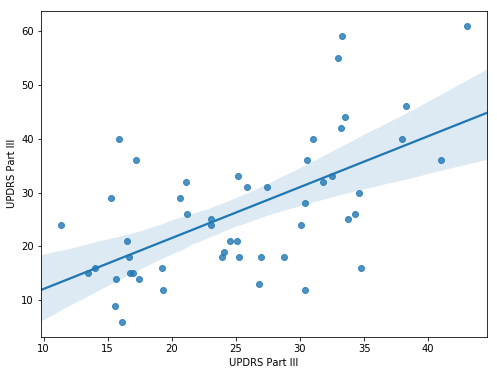

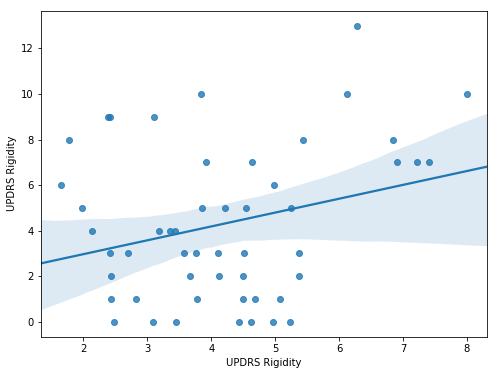

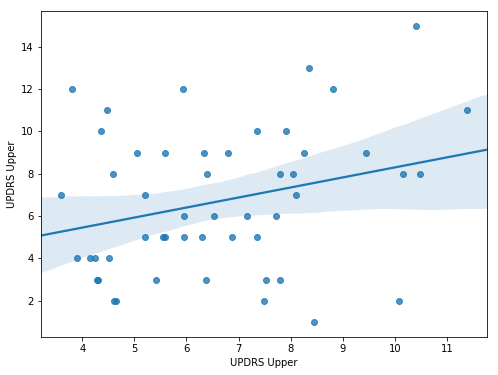

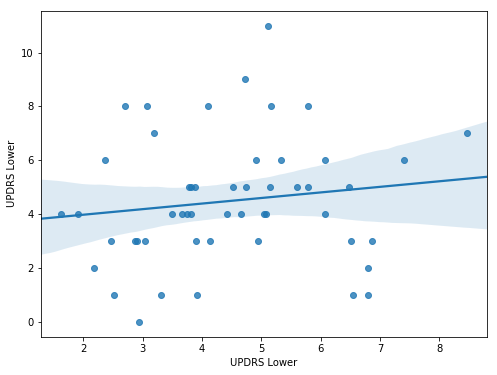

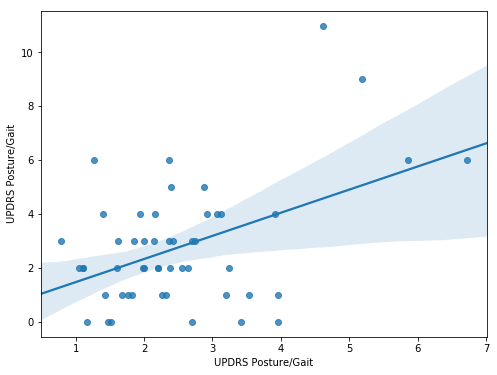

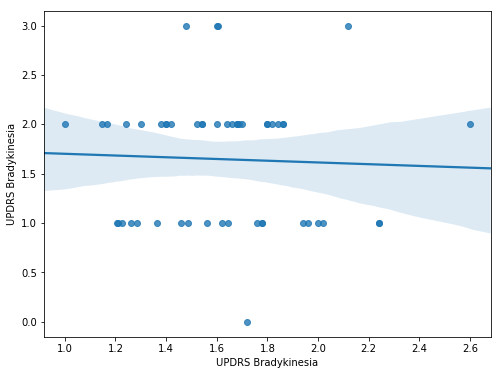

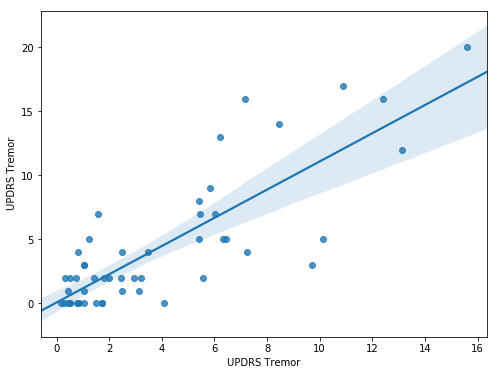

In [38]:
for column in Outcomes.columns:
    S = Outcomes[column].apply(lambda x: (x[0]-x[1])**2).sum()
    M = Outcomes[column].apply(lambda x: x[1]).mean()
    MD = Outcomes[column].apply(lambda x: (x[0]-x[1])).mean()
    SD = Outcomes[column].apply(lambda x: (x[0]-x[1])).std()
    print(column, np.sqrt(S), np.sqrt(S)/M, MD, SD, 
          pearsonr(Outcomes[column].apply(lambda x: x[0]),Outcomes[column].apply(lambda x: x[1])))
    plt.figure(figsize=(8,6))
    sns.regplot(Outcomes[column].apply(lambda x: x[0]),Outcomes[column].apply(lambda x: x[1]))

## Ipsilateral vs. Contralateral Scores

In [39]:
BilatScores = pd.DataFrame()

In [40]:
BilatScores = pd.DataFrame()
for ind in D.index:
    row = D.loc[ind,:]
    side = row.Q03
    try:
        side = side.lower()
        otherside = (set(['left','right'])-set([side]))
        otherside = [x for x in otherside][0]
    except(AttributeError):
        print(row.SubjectCode, row.VisitNm, row.Q03)
        continue
    for task, task_abr in zip(taskList,taskList_Abb):
        newind = len(BilatScores.index)
        RowScores = pd.DataFrame(columns=['ipsi', 'contra'], index=[ind])
        QInd = Questions.zFieldNm==task+' tremor '+side+' upper limb rating'
        QNum = Questions[QInd].zFieldNb
        RowScores['ipsi'] = row[QNum].values[0]
        QInd = Questions.zFieldNm==task+' tremor '+otherside+' upper limb rating'
        QNum = Questions[QInd].zFieldNb
        RowScores['contra'] = row[QNum].values[0]
        
        BilatScores = pd.concat((BilatScores,RowScores))

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
BilatScores.corr()

In [ ]:
BilatScores.corr()

In [ ]:
BilatScores.plot(x='ipsi',y='contra',kind = 'scatter')

In [ ]:
BilatScoreCounts = pd.DataFrame(columns=[0, 1, 2, 3, 4], index = [0, 1, 2, 3, 4])
for x,y in itertools.product([0,1,2,3,4],[0,1,2,3,4]):
    BilatScoreCounts.loc[x,y] = sum((BilatScores.ipsi==x)&(BilatScores.contra==y))/sum(BilatScores.ipsi==x)

In [ ]:
BilatScoreCounts = BilatScoreCounts[BilatScoreCounts.columns].astype(float)

In [ ]:
sns.heatmap(BilatScoreCounts)

## Predicting MDS from task Scores

In [84]:
BradyScores = pd.read_pickle('BradykinesiaPredictedScores_Class.pkl')
TremorScores = pd.read_pickle('TremorPredictedScores_Class.pkl')

In [69]:
VisitScores = pd.DataFrame()
nBoot = 1
for s,v in itertools.product(TremorScores.Subject.unique(), ['2 Weeks: Time 0', '2 Weeks: Time 60', '4 Weeks']):
    print(s,v)
    for i in range(nBoot):
        Row = pd.DataFrame(index = [(float(s),v)])
        for t in TremorScores.Task.unique():
            inds = (TremorScores.Subject==s)&(TremorScores.Visit==v)&(TremorScores.Task==t)
            if sum(inds)<1:
                try:
                    Row[t+'_TremorMean']
                    Row[t+'_TremorSD']
                except(KeyError):
                    Row[t+'_TremorMean'] = np.nan
                    Row[t+'_TremorSD'] = np.nan
                continue
                
            filtScores = TremorScores[inds]
#             bootInds = np.random.choice(filtScores.shape[0],size=filtScores.shape[0])
            bootInds = list(range(len(filtScores)))
            
            Row[t+'_TremorMean'] = filtScores.Scores.iloc[bootInds].mean()
            Row[t+'_TremorSD'] = filtScores.Scores.iloc[bootInds].std()
        for t in BradyScores.Task.unique():
            inds = (BradyScores.Subject==s)&(BradyScores.Visit==v)&(BradyScores.Task==t)
            if t[:3]=='Ftn':
                t = 'Ftn'
            if t[:3]=='Ram':
                t = 'Ram'
            if sum(inds)<1:
                try:
                    Row[t+'_BradyMean']
                    Row[t+'_BradySD']
                except(KeyError):
                    Row[t+'_BradyMean'] = np.nan
                    Row[t+'_BradySD'] = np.nan
                continue
                
            filtScores = BradyScores[inds]
#             bootInds = np.random.choice(filtScores.shape[0],size=filtScores.shape[0])
            bootInds = list(range(len(filtScores)))
            
            Row[t+'_BradyMean'] = filtScores.Scores.iloc[bootInds].mean()
            Row[t+'_BradySD'] = filtScores.Scores.iloc[bootInds].std()
        VisitScores = pd.concat([VisitScores,Row],axis=0)

1003 2 Weeks: Time 0
1003 2 Weeks: Time 60
1003 4 Weeks
1004 2 Weeks: Time 0
1004 2 Weeks: Time 60
1004 4 Weeks
1005 2 Weeks: Time 0
1005 2 Weeks: Time 60
1005 4 Weeks
1007 2 Weeks: Time 0
1007 2 Weeks: Time 60
1007 4 Weeks
1009 2 Weeks: Time 0
1009 2 Weeks: Time 60
1009 4 Weeks
1016 2 Weeks: Time 0
1016 2 Weeks: Time 60
1016 4 Weeks
1018 2 Weeks: Time 0
1018 2 Weeks: Time 60
1018 4 Weeks
1019 2 Weeks: Time 0
1019 2 Weeks: Time 60
1019 4 Weeks
1023 2 Weeks: Time 0
1023 2 Weeks: Time 60
1023 4 Weeks
1024 2 Weeks: Time 0
1024 2 Weeks: Time 60
1024 4 Weeks
1029 2 Weeks: Time 0
1029 2 Weeks: Time 60
1029 4 Weeks
1030 2 Weeks: Time 0
1030 2 Weeks: Time 60
1030 4 Weeks
1032 2 Weeks: Time 0
1032 2 Weeks: Time 60
1032 4 Weeks
1038 2 Weeks: Time 0
1038 2 Weeks: Time 60
1038 4 Weeks
1039 2 Weeks: Time 0
1039 2 Weeks: Time 60
1039 4 Weeks
1043 2 Weeks: Time 0
1043 2 Weeks: Time 60
1043 4 Weeks
1044 2 Weeks: Time 0
1044 2 Weeks: Time 60
1044 4 Weeks
1046 2 Weeks: Time 0
1046 2 Weeks: Time 60
1046 

In [70]:
VisitScores.shape

(66, 50)

In [71]:
VisitScores = VisitScores[[not any(row[1].isnull()) for row in VisitScores.iterrows()]]

In [72]:
VisitScores_orig = VisitScores.copy()

In [73]:
VisitScores = pd.merge(VisitScores_orig,UPDRS,left_index=True,right_index=True)

In [74]:
VisitScores.index = pd.MultiIndex.from_tuples(VisitScores.index, names=['first', 'second'])

In [75]:
VisitScores = VisitScores[[not any(row[1].isnull()) for row in VisitScores.iterrows()]]

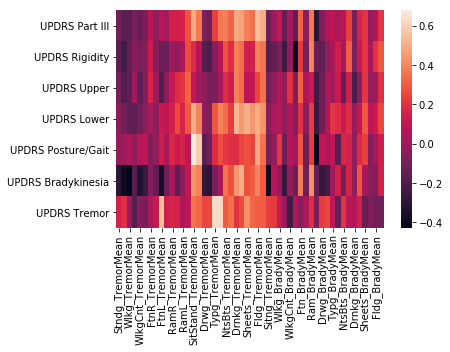

In [76]:
sns.heatmap(VisitScores.corr().iloc[50:,:50])

In [77]:
VisitScores

Stndg_TremorMean  Stndg_TremorSD  Wlkg_TremorMean  \
first  second                                                                
1003.0 2 Weeks: Time 0           0.000000        0.000000         0.000000   
       2 Weeks: Time 60          0.000000        0.000000         0.000000   
1004.0 2 Weeks: Time 0           0.000000        0.000000         0.000000   
1005.0 2 Weeks: Time 60          0.000000        0.000000         0.000000   
1007.0 2 Weeks: Time 0           0.000000        0.000000         0.000000   
       2 Weeks: Time 60          0.000000        0.000000         0.000000   
1009.0 2 Weeks: Time 60          0.000000        0.000000         0.000000   
1016.0 2 Weeks: Time 0           0.000000        0.000000         0.000000   
       2 Weeks: Time 60          0.000000        0.000000         0.062500   
1018.0 2 Weeks: Time 0           0.000000        0.000000         0.000000   
       2 Weeks: Time 60          0.000000        0.000000         0.000000   
1019.0 2 Weeks: Time 0           0.000000        0.000000         0.000000   
       2 Weeks: Time 60          0.000000        0.000000         0.000000   
1023.0 2 Weeks: Time 0           0.000000        0.000000         0.000000   
       2 Weeks: Time 60          0.000000        0.000000         0.923077   
1029.0 2 Weeks: Time 0           0.000000        0.000000         0.000000   
       2 Weeks: Time 60          0.000000        0.000000         0.000000   
1032.0 2 Weeks: Time 0           0.000000        0.000000         0.000000   
       2 Weeks: Time 60          0.000000        0.000000         0.000000   
1038.0 2 Weeks: Time 0           0.000000        0.000000         0.000000   
       2 Weeks: Time 60          0.000000        0.000000         0.000000   
1039.0 2 Weeks: Time 0           0.000000        0.000000         0.000000   
       2 Weeks: Time 60          0.000000        0.000000         0.000000   
1043.0 2 Weeks: Time 0           0.000000        0.000000         0.000000   
       2 Weeks: Time 60          0.000000        0.000000         0.000000   
1044.0 2 Weeks: Time 0           0.000000        0.000000         0.307692   
       2 Weeks: Time 60          0.000000        0.000000         0.222222   
1046.0 2 Weeks: Time 0           0.000000        0.000000         0.000000   
       2 Weeks: Time 60          0.250000        0.452267         0.000000   
1048.0 2 Weeks: Time 0           0.500000        0.849837         2.555556   
1049.0 2 Weeks: Time 60          0.083333        0.288675         0.000000   
1050.0 2 Weeks: Time 60          1.100000        0.737865         0.071429   
1051.0 2 Weeks: Time 0           0.000000        0.000000         0.000000   
       2 Weeks: Time 60          0.000000        0.000000         0.000000   

                         Wlkg_TremorSD  WlkgCnt_TremorMean  WlkgCnt_TremorSD  \
first  second                                                                  
1003.0 2 Weeks: Time 0        0.000000            0.062500          0.250000   
       2 Weeks: Time 60       0.000000            0.000000          0.000000   
1004.0 2 Weeks: Time 0        0.000000            0.000000          0.000000   
1005.0 2 Weeks: Time 60       0.000000            0.000000          0.000000   
1007.0 2 Weeks: Time 0        0.000000            0.000000          0.000000   
       2 Weeks: Time 60       0.000000            0.000000          0.000000   
1009.0 2 Weeks: Time 60       0.000000            0.000000          0.000000   
1016.0 2 Weeks: Time 0        0.000000            0.000000          0.000000   
       2 Weeks: Time 60       0.250000            0.000000          0.000000   
1018.0 2 Weeks: Time 0        0.000000            0.000000          0.000000   
       2 Weeks: Time 60       0.000000            0.000000          0.000000   
1019.0 2 Weeks: Time 0        0.000000            0.000000          0.000000   
       2 Weeks: Time 60       0.000000            0.000000          0.000000   
1023.0 2 Weeks: 

In [81]:
cf = RandomForestRegressor(n_estimators=50)
grouper = LeaveOneGroupOut()

Outcomes = pd.DataFrame(index=range(VisitScores.shape[0]),columns = ['UPDRS Part III', 'UPDRS Rigidity', 'UPDRS Upper', 
                                                                    'UPDRS Lower', 'UPDRS Posture/Gait', 'UPDRS Bradykinesia', 
                                                                    'UPDRS Tremor'])
FeatImp = np.array([])
indMax = 0
for subj in VisitScores.index.levels[0]:
    try:
        if len(VisitScores.loc[subj])<1:
            continue
    except(KeyError):
        continue
    for Target in Outcomes.columns:
        Train = VisitScores.drop(index=subj,level='first')
        Test = VisitScores.loc[subj]

        TrainFeat = Train.drop(columns=['UPDRS Part III', 'UPDRS Rigidity', 'UPDRS Upper', 'UPDRS Lower', 
                                        'UPDRS Posture/Gait', 'UPDRS Bradykinesia', 'UPDRS Tremor']).values 
#                                         'FtnR_TremorMean', 'FtnR_TremorSD', 'FtnL_TremorMean', 'FtnL_TremorSD',
#                                         'RamR_TremorMean', 'RamR_TremorSD', 'RamL_TremorMean', 'RamL_TremorSD',
#                                         'Ftn_BradyMean', 'Ftn_BradySD', 'Ram_BradyMean', 'Ram_BradySD']).values
        TrainScores = Train[Target].values

        TestFeat = Test.drop(columns=['UPDRS Part III', 'UPDRS Rigidity', 'UPDRS Upper', 'UPDRS Lower', 
                                      'UPDRS Posture/Gait', 'UPDRS Bradykinesia', 'UPDRS Tremor']).values
#                                       'FtnR_TremorMean', 'FtnR_TremorSD', 'FtnL_TremorMean', 'FtnL_TremorSD',
#                                       'RamR_TremorMean', 'RamR_TremorSD', 'RamL_TremorMean', 'RamL_TremorSD',
#                                       'Ftn_BradyMean', 'Ftn_BradySD', 'Ram_BradyMean', 'Ram_BradySD']).values
        TestScores = Test[Target]
        
        cf.fit(TrainFeat,TrainScores)
        if Target=='UPDRS Part III':
            if len(FeatImp)>1:
                FeatImp=np.vstack((FeatImp,cf.feature_importances_))
            else:
                FeatImp = cf.feature_importances_
        pred = cf.predict(TestFeat)
        for ind in range(TestScores.shape[0]):
            Outcomes.loc[ind+indMax,Target] = (pred[ind],TestScores.iloc[ind])
    indMax = indMax+ind+1

In [82]:
Outcomes

,UPDRS Part III,UPDRS Rigidity,UPDRS Upper,UPDRS Lower,UPDRS Posture/Gait,UPDRS Bradykinesia,UPDRS Tremor
0,"(28.2, 59.0)","(4.74, 9.0)","(7.06, 13.0)","(5.24, 11.0)","(3.34, 11.0)","(1.76, 3.0)","(3.52, 8.0)"
1,"(25.92, 40.0)","(3.48, 9.0)","(7.22, 12.0)","(4.22, 6.0)","(2.94, 3.0)","(1.78, 2.0)","(4.18, 5.0)"
2,"(32.22, 31.0)","(5.7, 5.0)","(7.4, 9.0)","(5.62, 8.0)","(4.42, 1.0)","(2.2, 2.0)","(4.7, 4.0)"
3,"(21.82, 32.0)","(3.18, 7.0)","(5.06, 8.0)","(3.46, 5.0)","(3.0, 2.0)","(1.32, 1.0)","(3.32, 7.0)"
4,"(20.08, 33.0)","(4.34, 5.0)","(6.5, 10.0)","(4.24, 7.0)","(2.84, 2.0)","(1.82, 2.0)","(0.8, 7.0)"
5,"(27.56, 16.0)","(3.64, 0.0)","(7.62, 7.0)","(4.26, 4.0)","(2.98, 1.0)","(1.66, 1.0)","(2.4, 2.0)"
6,"(21.32, 26.0)","(4.34, 7.0)","(5.58, 5.0)","(3.48, 4.0)","(3.0, 2.0)","(1.76, 2.0)","(1.9, 4.0)"
7,"(20.22, 19.0)","(3.08, 0.0)","(6.24, 6.0)","(4.34, 4.0)","(1.6, 4.0)","(1.14, 2.0)","(2.52, 1.0)"
8,"(20.34, 21.0)","(4.94, 0.0)","(6.64, 5.0)","(3.7, 4.0)","(2.36, 6.0)","(1.68, 2.0)","(2.02, 2.0)"
9,"(24.32, 18.0)","(3.94, 4.0)","(6.92, 5.0)","(4.46, 4.0)","(3.92, 0.0)","(1.66, 1.0)","(2.68, 2.0)"


UPDRS Part III 61.399771986547314 2.43593027717924 -0.9294117647058822 10.646613614745094 (0.25551006580158975, 0.1447096426583489)
UPDRS Rigidity 20.456861929435807 4.932860323410052 0.0011764705882352428 3.5610823726620158 (-0.14639346014164983, 0.40871954936430244)
UPDRS Upper 23.37425934655471 3.596039899469955 0.23647058823529404 4.061850513007321 (-0.21350463313653484, 0.22535579069086922)
UPDRS Lower 12.774834636894521 2.820418036716972 -0.23941176470588246 2.2104955445747154 (0.19094066374984925, 0.2793805729695594)
UPDRS Posture/Gait 13.26680066933999 4.7481181342901015 0.2129411764705882 2.299316801576219 (0.12369593076852486, 0.48582125826474465)
UPDRS Bradykinesia 3.978341362930034 2.4593382970840207 -0.024705882352941133 0.6920861537458857 (0.21266696018581124, 0.22722423789511523)
UPDRS Tremor 18.395792997313272 5.634747404582444 -0.13705882352941187 3.199273146060149 (0.1960142251956483, 0.26656028176815166)


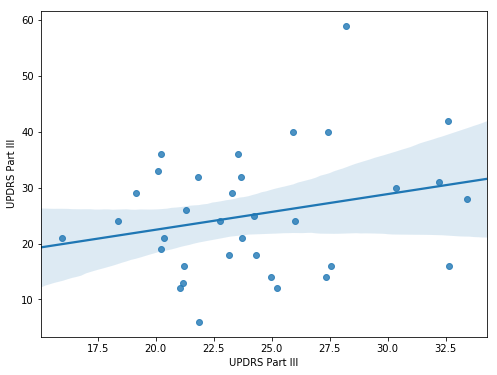

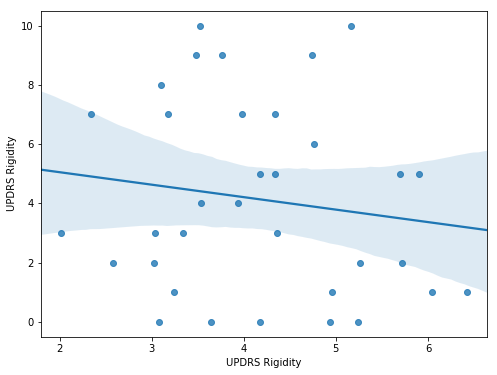

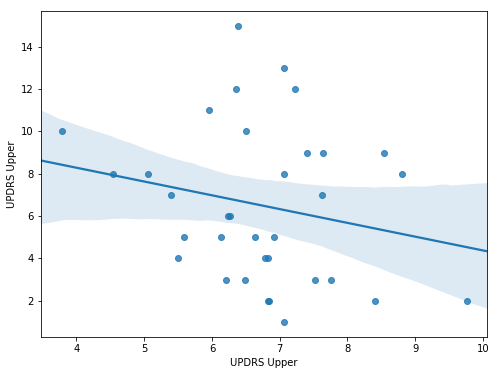

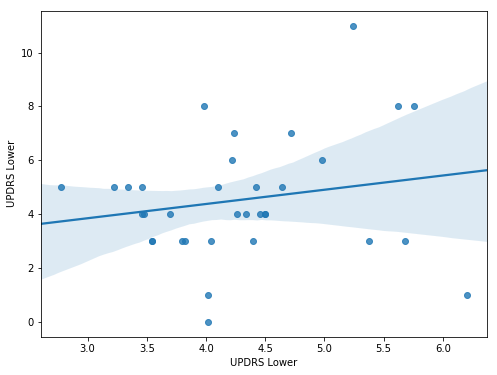

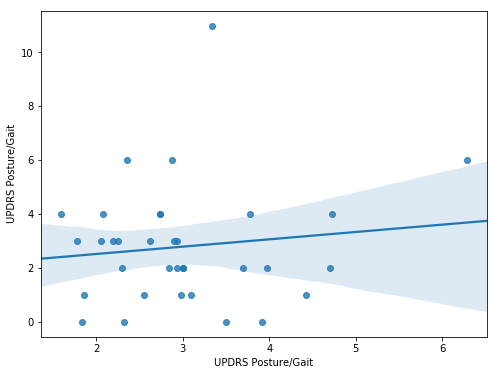

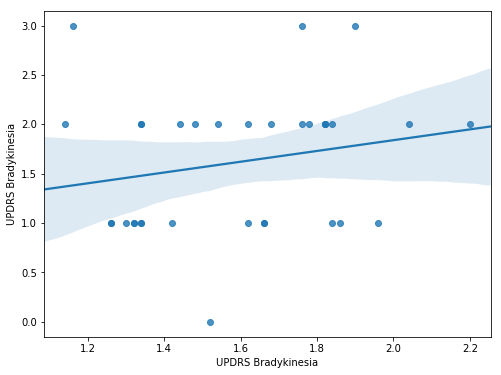

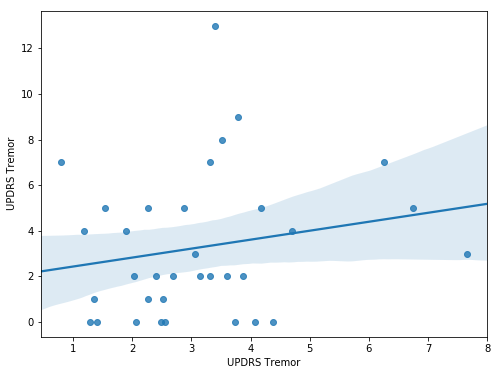

In [83]:
for column in Outcomes.columns:
    S = Outcomes[column].apply(lambda x: (x[0]-x[1])**2).sum()
    M = Outcomes[column].apply(lambda x: x[1]).mean()
    MD = Outcomes[column].apply(lambda x: (x[0]-x[1])).mean()
    SD = Outcomes[column].apply(lambda x: (x[0]-x[1])).std()
    print(column, np.sqrt(S), np.sqrt(S)/M, MD, SD, 
          pearsonr(Outcomes[column].apply(lambda x: x[0]),Outcomes[column].apply(lambda x: x[1])))
    plt.figure(figsize=(8,6))
    sns.regplot(Outcomes[column].apply(lambda x: x[0]),Outcomes[column].apply(lambda x: x[1]))

In [ ]:
for column in Outcomes.columns:
    S = Outcomes[column].apply(lambda x: (x[0]-x[1])**2).sum()
    M = Outcomes[column].apply(lambda x: x[1]).mean()
    MD = Outcomes[column].apply(lambda x: (x[0]-x[1])).mean()
    SD = Outcomes[column].apply(lambda x: (x[0]-x[1])).std()
    print(column, np.sqrt(S), np.sqrt(S)/M, MD, SD, 
          pearsonr(Outcomes[column].apply(lambda x: x[0]),Outcomes[column].apply(lambda x: x[1])))
    plt.figure(figsize=(8,6))
    sns.regplot(Outcomes[column].apply(lambda x: x[0]),Outcomes[column].apply(lambda x: x[1]))

In [ ]:
FeatImp

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]), <a list of 38 Text xticklabel objects>)

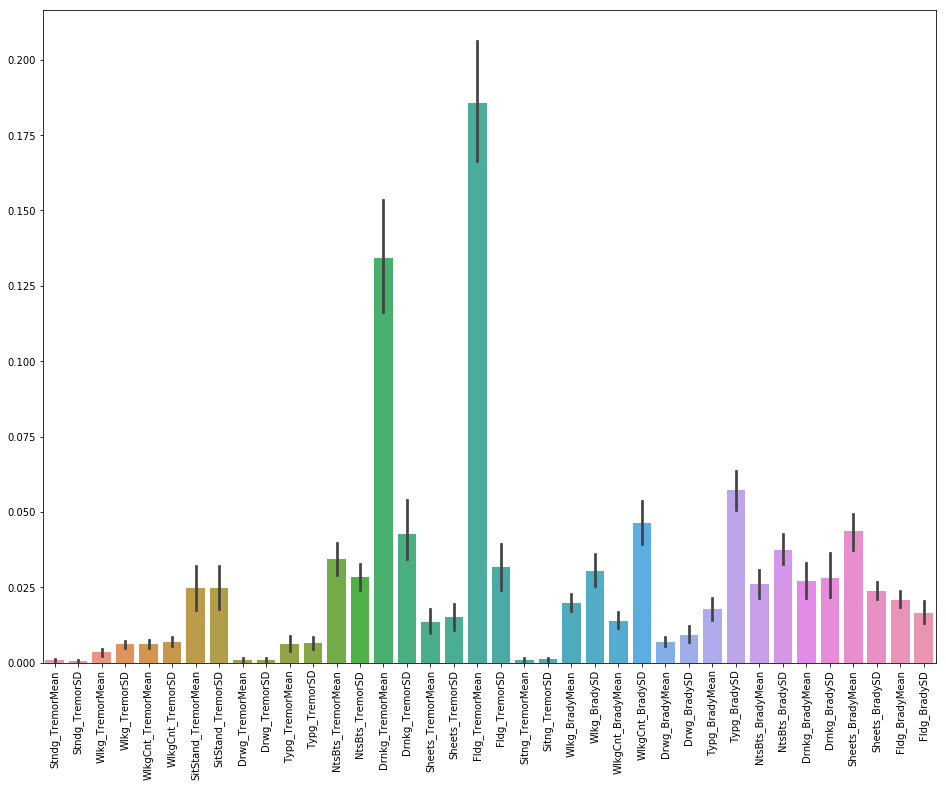

In [266]:
plt.figure(figsize=(16,12))
sns.barplot(data = pd.DataFrame(FeatImp,columns = VisitScores.drop(columns=['UPDRS Part III', 'UPDRS Rigidity', 'UPDRS Upper', 'UPDRS Lower', 
                                      'UPDRS Posture/Gait', 'UPDRS Bradykinesia', 'UPDRS Tremor',
                                      'FtnR_TremorMean', 'FtnR_TremorSD', 'FtnL_TremorMean', 'FtnL_TremorSD',
                                      'RamR_TremorMean', 'RamR_TremorSD', 'RamL_TremorMean', 'RamL_TremorSD',
                                      'Ftn_BradyMean', 'Ftn_BradySD', 'Ram_BradyMean', 'Ram_BradySD']).columns))
plt.xticks(rotation=90)